# Descarga y visualización de incendios y anomalías termales de FIRMS

## Bibliotecas

In [ ]:
!pip install -q lonboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.2/928.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.6 MB/s eta 0:00:00


In [ ]:
import io
import time
from datetime import datetime
from datetime import timedelta
import zoneinfo

import requests
from requests.exceptions import HTTPError

import matplotlib.pyplot as plt
from matplotlib import colormaps as mpl_cmaps

import numpy as np
import pandas as pd

from shapely import wkt
import geopandas as gpd

import lonboard as lb
from lonboard import Map, ScatterplotLayer
from lonboard.basemap import CartoBasemap

## Parámetros generales

In [ ]:
# Fuente de datos a consultar en FIRMS
SOURCE = 'MODIS_SP'

# Llave del API (MAP_KEY)
MAP_KEY = '94f5467949bf41a2d6352ac8bc8280a1'

In [ ]:
# Archivo con área para recortar
CLIP_AREA_URL = 'https://github.com/incendios-forestales/datos/raw/refs/heads/main/costarica.gpkg'

# Archivo de salida en formato CSV
OUTPUT_CSV = 'incendios-cr-modis.csv'

# Archivo de salida en formato GPKG
OUTPUT_GPKG = 'incendios-cr-modis.gpkg'

# Archivo de salida en formato GeoParquet
OUTPUT_GEOPARQUET = 'incendios-cr-modis.geoparquet'

<Axes: >

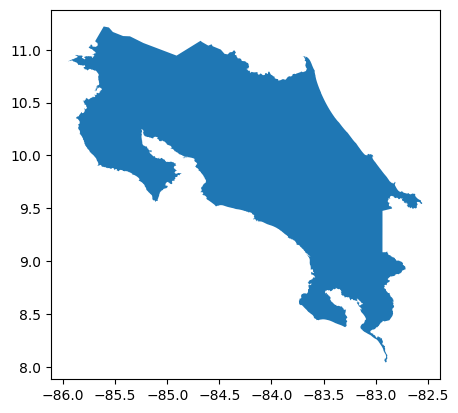

In [ ]:
# Cargar archivo con área para recortar
clip_gdf = gpd.read_file(CLIP_AREA_URL)

# Desplegar el área
clip_gdf.plot()

In [ ]:
# Obtener límites del área para recortar los incendios
minx, miny, maxx, maxy = clip_gdf.total_bounds

# Formato requerido por FIRMS: Oeste, Sur, Este, Norte
AREA_COORDINATES = f"{minx:.6f},{miny:.6f},{maxx:.6f},{maxy:.6f}"

# Imprimir las coordenadas
print(f"AREA_COORDINATES: {AREA_COORDINATES}")

AREA_COORDINATES: -85.949914,8.040082,-82.552846,11.219639


In [ ]:
# Probar estado del MAP_KEY
status_url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  response = requests.get(status_url)
  data = response.json()
  df = pd.Series(data)
  display(df)
except:
  print (f"La consulta falló. \nPruébela en su navegador: {status_url}")

,0
transaction_limit,5000
current_transactions,0
transaction_interval,10 minutes


In [ ]:
# Desplegar conjuntos de datos disponibles
data_availability_url = 'https://firms.modaps.eosdis.nasa.gov/api/data_availability/csv/' + MAP_KEY + '/all'
df = pd.read_csv(data_availability_url)
display(df)

,data_id,min_date,max_date
0,MODIS_NRT,2025-08-01,2025-10-29
1,MODIS_SP,2000-11-01,2025-07-31
2,VIIRS_NOAA20_NRT,2025-07-01,2025-10-29
3,VIIRS_NOAA20_SP,2018-04-01,2025-06-30
4,VIIRS_NOAA21_NRT,2024-01-17,2025-10-29
5,VIIRS_SNPP_NRT,2025-07-01,2025-10-29
6,VIIRS_SNPP_SP,2012-01-20,2025-06-30
7,LANDSAT_NRT,2022-06-20,2025-10-21
8,GOES_NRT,2022-08-09,2025-10-29
9,BA_MODIS,2000-11-01,2025-08-01


In [ ]:
# Recuperar fechas mínima y máxima de datos disponibles
# en el conjunto seleccionado
idx = df.set_index('data_id')
DATE_MIN = pd.to_datetime(idx.at[SOURCE, 'min_date']).date().isoformat()
DATE_MAX = pd.to_datetime(idx.at[SOURCE, 'max_date']).date().isoformat()

# Imprimir fechas
print(f"DATE_MIN: {DATE_MIN}")
print(f"DATE_MAX: {DATE_MAX}")

DATE_MIN: 2000-11-01
DATE_MAX: 2025-07-31


## Obtención de datos

In [ ]:
# --- Función: estado del MAP_KEY (devuelve current_transactions como int o None) ---
def get_current_transactions(map_key: str, timeout: int = 15):
    status_url = f"https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY={map_key}"
    try:
        r = requests.get(status_url, timeout=timeout)
        r.raise_for_status()
        data = r.json()
        return int(data.get("current_transactions")) if "current_transactions" in data else None
    except Exception as e:
        print(f"Aviso: no fue posible obtener el estado del MAP_KEY ({e}). URL: {status_url}")
        return None

# --- Función: esperar hasta que current_transactions == 0, imprimiendo progreso ---
def wait_for_quota_reset(map_key: str, poll_seconds: int = 15, max_wait_seconds: int | None = None):
    """
    Revisa periódicamente el estado del MAP_KEY hasta que current_transactions == 0.
    Imprime current_transactions y el tiempo total transcurrido de espera.
    Si max_wait_seconds es None, espera indefinidamente.
    """
    start_t = time.monotonic()
    while True:
        ct = get_current_transactions(map_key)
        elapsed = int(time.monotonic() - start_t)
        mm, ss = divmod(elapsed, 60)
        if ct == 0:
            print(f"   -> current_transactions=0 | espera total={mm:02d}:{ss:02d}. Se reanuda el procesamiento.")
            return
        print(f"   -> En espera: current_transactions={ct} | tiempo_espera={mm:02d}:{ss:02d}")
        if max_wait_seconds is not None and elapsed >= max_wait_seconds:
            raise TimeoutError(f"Se alcanzó el tiempo máximo de espera ({max_wait_seconds}s) sin que current_transactions llegue a 0.")
        time.sleep(poll_seconds)

# --- Función: descargar CSV con manejo explícito de código HTTP ---
def fetch_firms_csv(url: str, timeout: int = 60) -> pd.DataFrame:
    """
    Realiza GET con requests para poder inspeccionar el status code.
    Si 200: parsea CSV con pandas; si 403: relanza el HTTPError para que el caller decida esperar.
    Otros códigos: relanza el HTTPError.
    """
    r = requests.get(url, timeout=timeout)
    try:
        r.raise_for_status()
    except HTTPError:
        # Adjuntar la respuesta para inspección del status_code aguas arriba
        raise
    # Parsear CSV
    return pd.read_csv(io.StringIO(r.text))

In [ ]:
# Para pruebas:
# DATE_MIN = '2001-01-01'
# DATE_MAX = '2001-12-31'

MAX_CHUNK_DAYS = 10  # tamaño del bloque de días a consultar
start = pd.to_datetime(DATE_MIN).date()
end   = pd.to_datetime(DATE_MAX).date()
if start > end:
    raise ValueError("DATE_MIN no puede ser mayor que DATE_MAX")

dfs = []     # lista de dataframes retornados por las consultas
cum_rows = 0 # contador de registros retornados
cur = start  # se inicializa la fecha actual de consulta con la fecha inicial

# Se ejecutan consultas de MAX_CHUNK_DAYS días
# mientras la fecha actual sea menor que la fecha final
while cur <= end:
    days_remaining = (end - cur).days + 1
    day_range = min(MAX_CHUNK_DAYS, days_remaining)
    chunk_end = cur + timedelta(days=day_range - 1)

    query_area_url = (
        f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/"
        f"{MAP_KEY}/{SOURCE}/{AREA_COORDINATES}/{day_range}/{cur.isoformat()}"
    )

    while True:
        # Pre-chequeo de cuota ---
        ct_pre = get_current_transactions(MAP_KEY)
        if ct_pre is not None and ct_pre >= 5000:
            print(f"[{cur}..{chunk_end}] current_transactions={ct_pre} (>=5000). "
                  "Esperando a que current_transactions vuelva a 0...")
            wait_for_quota_reset(MAP_KEY, poll_seconds=15, max_wait_seconds=None)
            continue

        try:
            tmp = fetch_firms_csv(query_area_url)
            # Si el bloque trae datos, acumular
            if isinstance(tmp, pd.DataFrame) and not tmp.empty:
                dfs.append(tmp)
                cum_rows += len(tmp)

            # Tras cada llamado exitoso, reportar current_transactions y acumulado
            ct = get_current_transactions(MAP_KEY)
            print(f"[{cur}..{chunk_end}] OK | registros_retornados={len(tmp)} | registros_acumulados={cum_rows} | current_transactions={ct} | {query_area_url}")
            break  # salir del bucle de reintento para pasar al siguiente bloque

        except HTTPError as e:
            status = e.response.status_code if getattr(e, "response", None) is not None else None
            if status == 403:
                print(f"[{cur}..{chunk_end}] 403 Forbidden: límite de transacciones alcanzado. "
                      f"Esperando a que current_transactions vuelva a 0...")
                # Esperar hasta que el contador se reinicie a 0
                wait_for_quota_reset(MAP_KEY, poll_seconds=15, max_wait_seconds=None)
                # Al salir, reintentar el mismo bloque
                continue
            else:
                print(f"[{cur}..{chunk_end}] Error HTTP {status}: {e}. Se continuará con el siguiente bloque.")
                break  # abandonar este bloque y pasar al siguiente

        except Exception as e:
            print(f"[{cur}..{chunk_end}] Error no HTTP: {e}. Se continuará con el siguiente bloque.")
            break  # abandonar este bloque y pasar al siguiente

    cur += timedelta(days=day_range)

# Unir todos los dataframes retornados por las consultas
df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
# Eliminar duplicados (por si acaso)
if not df.empty:
    df = df.drop_duplicates()

[2000-11-01..2000-11-10] OK | registros_retornados=3 | registros_acumulados=3 | current_transactions=25 | https://firms.modaps.eosdis.nasa.gov/api/area/csv/94f5467949bf41a2d6352ac8bc8280a1/MODIS_SP/-85.949914,8.040082,-82.552846,11.219639/10/2000-11-01
[2000-11-11..2000-11-20] OK | registros_retornados=0 | registros_acumulados=3 | current_transactions=45 | https://firms.modaps.eosdis.nasa.gov/api/area/csv/94f5467949bf41a2d6352ac8bc8280a1/MODIS_SP/-85.949914,8.040082,-82.552846,11.219639/10/2000-11-11
[2000-11-21..2000-11-30] OK | registros_retornados=1 | registros_acumulados=4 | current_transactions=65 | https://firms.modaps.eosdis.nasa.gov/api/area/csv/94f5467949bf41a2d6352ac8bc8280a1/MODIS_SP/-85.949914,8.040082,-82.552846,11.219639/10/2000-11-21
[2000-12-01..2000-12-10] OK | registros_retornados=4 | registros_acumulados=8 | current_transactions=85 | https://firms.modaps.eosdis.nasa.gov/api/area/csv/94f5467949bf41a2d6352ac8bc8280a1/MODIS_SP/-85.949914,8.040082,-82.552846,11.219639/10

In [ ]:
# Convertir a un geodataframe la unión de todos los dataframes
non_clipped_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# Desplegar el geodataframe
display(non_clipped_gdf)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,geometry
0,10.4644,-84.7059,307.0,1.4,1.2,2000-11-08,1643,Terra,MODIS,34,6.03,290.6,7.1,D,1,POINT (-84.7059 10.4644)
1,10.4648,-84.7029,314.2,1.0,1.0,2000-11-10,415,Terra,MODIS,89,6.03,287.1,13.1,N,1,POINT (-84.7029 10.4648)
2,10.4651,-84.6987,316.4,1.0,1.0,2000-11-10,1631,Terra,MODIS,67,6.03,288.8,11.6,D,1,POINT (-84.6987 10.4651)
3,10.4148,-85.5350,321.3,1.0,1.0,2000-11-26,1630,Terra,MODIS,54,6.03,303.7,11.0,D,0,POINT (-85.535 10.4148)
4,10.8507,-85.9111,316.9,1.0,1.0,2000-12-03,1636,Terra,MODIS,39,6.03,293.6,10.8,D,3,POINT (-85.9111 10.8507)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31975,9.2726,-83.3566,326.3,1.0,1.0,2025-07-16,2017,Aqua,MODIS,82,61.03,296.4,20.9,D,0,POINT (-83.3566 9.2726)
31976,9.2739,-83.3475,314.6,1.0,1.0,2025-07-16,2017,Aqua,MODIS,69,61.03,296.7,9.1,D,0,POINT (-83.3475 9.2739)
31977,9.9622,-84.1515,300.1,1.9,1.3,2025-07-24,808,Aqua,MODIS,16,61.03,273.2,15.7,N,2,POINT (-84.1515 9.9622)
31978,10.1504,-85.4556,315.4,1.2,1.1,2025-07-26,2012,Aqua,MODIS,25,61.03,298.3,9.9,D,2,POINT (-85.4556 10.1504)


Cantidad de incendios sin recortar: 31980


<Axes: >

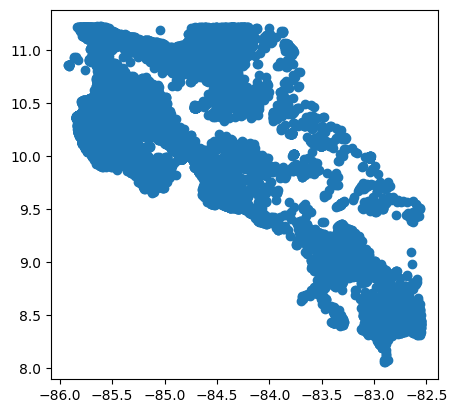

In [ ]:
# Imprimir la cantidad de incendios sin recortar
print(f"Cantidad de incendios sin recortar: {len(non_clipped_gdf)}")

# Desplegar incendios sin recortar
non_clipped_gdf.plot()

# Recorte

Cantidad de incendios recortados: 28441


<Axes: >

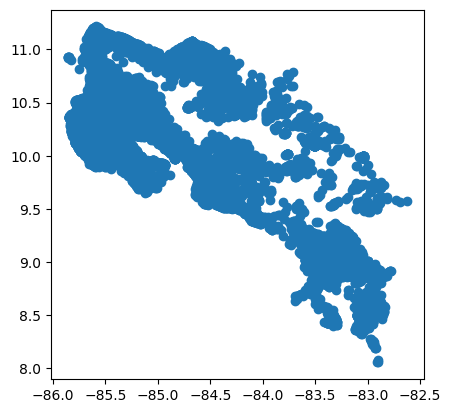

In [ ]:
# Recortar los incendios
gdf = gpd.sjoin(non_clipped_gdf, clip_gdf, how="inner", predicate="intersects")

# Imprimir la cantidad de incendios recortados
print(f"Cantidad de incendios recortados: {len(gdf)}")

# Desplegar incendios recortados
gdf.plot()

## Mapa

In [ ]:
# Normalizar FRP (NaN/outliers/NumPy 2.0)
vals = gdf["frp"].to_numpy(dtype="float64")
finite = np.isfinite(vals)

if finite.any():
    # Recortar outliers a percentiles 2–98
    lo, hi = np.nanpercentile(vals[finite], [2, 98])
    denom = max(hi - lo, 1e-9)
    scaled = np.clip((vals - lo) / denom, 0, 1)
else:
    scaled = np.zeros_like(vals)

# Color continuo -> RGBA uint8
cmap = mpl_cmaps['inferno']
rgba = (cmap(scaled) * 255).astype('uint8')  # escalado en [0,1]

# Radio en metros (mayor FRP -> punto más grande)
radii = (30 + 170 * scaled).astype("float32")  # 30–200 m aprox.

# Definir la capa lonboard de puntos de incendios
layer = ScatterplotLayer.from_geopandas(
    gdf,
    get_fill_color=rgba,       # Nx4 RGBA
    get_radius=radii,          # array de radios
    radius_min_pixels=2,       # asegura visibilidad
    pickable=True              # necesario para tooltip
)

# Definir el mapa
m = Map(
    layer,
    basemap_style=CartoBasemap.Positron,
    show_tooltip=False,        # muestra atributos al pasar el ratón
    height="650px",
    use_device_pixels=False    # mejora rendimiento en pantallas HiDPI
)

# Desplegar el mapa
m

Map(basemap_style=<CartoBasemap.Positron: 'https://basemaps.cartocdn.com/gl/positron-gl-style/style.json'>, cu…

## Exportación

In [ ]:
# A CSV
gdf.to_csv(OUTPUT_CSV)

In [ ]:
# A GPKG
gdf.to_file(OUTPUT_GPKG)

In [ ]:
# A GeoParquet
gdf.to_parquet(OUTPUT_GEOPARQUET)